Procesamiento de datos en SQLAlchemy usando SQL y Pandas
===

Este tutorial esta basado en https://es.hortonworks.com/tutorial/how-to-process-data-with-apache-hive/

Fuentes de datos
---

In [1]:
import pandas as pd
import glob

filenames = [
    "drivers.csv",
    "timesheet.csv",
    "truck_event_text_partition.csv",
]

url = "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/drivers/"

for filename in filenames:
    pd.read_csv(url+filename).to_csv("/tmp/" + filename, index=False)
    
glob.glob("/tmp/*.csv")

['/tmp/summary.csv',
 '/tmp/timesheet.csv',
 '/tmp/drivers.csv',
 '/tmp/truck_event_text_partition.csv']

In [2]:
#
# Se imprime el final del archivo drivers
#
# !tail -n 5 /tmp/drivers.csv
#
with open('/tmp/drivers.csv', 'rt') as file:
    lines = file.readlines()

for line in lines[-5:]:
    print(line, end="")

39,David Kaiser,967706052,9185 At Street,Y,hours
40,Nicolas Maillard,208510217,1027 Quis Rd.,Y,hours
41,Greg Phillips,308103116,P.O. Box 847- 5961 Arcu. Road,Y,hours
42,Randy Gelhausen,853302254,145-4200 In- Avenue,Y,hours
43,Dave Patton,977706052,3028 A- St.,Y,hours


In [3]:
#
# !tail -n 5 /tmp/timesheet.csv
#
with open('/tmp/timesheet.csv', 'rt') as file:
    lines = file.readlines()

for line in lines[-5:]:
    print(line, end="")

43,48,52,2517
43,49,56,2743
43,50,59,2665
43,51,58,2593
43,52,48,2764


Creación de la máquina
---

In [4]:
from sqlalchemy import create_engine

#
# "sqlite+pysqlite:///:memory:"
#
#  sqlite:  indica el dialecto o motor de base de datos
#  pysqlite: indica el driver de base de datos
#  :memory: indica que la base de datos se almacenará en memoria
#           o la ubicación fisica de la base de datos
#
engine = create_engine(
    "sqlite+pysqlite:///:memory:",  
    echo=True, 
    future=True,
)

Creación y carga de datos de datos para la tabla `drivers` usando pandas
---

In [5]:
import pandas as pd

drivers = pd.read_csv(
    "/tmp/drivers.csv",
    sep=",",
    thousands=None,
    decimal=".",
    encoding="latin-1",
)

drivers.columns = [col.replace("-", "_") for col in drivers.columns]

drivers.to_sql(
    "drivers",
    con=engine,
    if_exists="replace",
    index=False,
)

2023-04-03 17:32:51,200 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-03 17:32:51,201 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("drivers")
2023-04-03 17:32:51,201 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-03 17:32:51,204 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("drivers")
2023-04-03 17:32:51,205 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-03 17:32:51,205 INFO sqlalchemy.engine.Engine ROLLBACK
2023-04-03 17:32:51,207 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-03 17:32:51,208 INFO sqlalchemy.engine.Engine 
CREATE TABLE drivers (
	"driverId" BIGINT, 
	name TEXT, 
	ssn BIGINT, 
	location TEXT, 
	certified TEXT, 
	wage_plan TEXT
)


2023-04-03 17:32:51,209 INFO sqlalchemy.engine.Engine [no key 0.00113s] ()
2023-04-03 17:32:51,210 INFO sqlalchemy.engine.Engine COMMIT
2023-04-03 17:32:51,212 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-03 17:32:51,215 INFO sqlalchemy.engine.Engine INSERT INTO drivers ("driverId", name, ssn,

34

In [6]:
#
# Verificación
#
from sqlalchemy.sql import text

sql = """
    SELECT * FROM drivers LIMIT 5;
"""
with engine.connect().execution_options(autocommit=True) as conn:
    query = conn.execute(text(sql))

pd.DataFrame(query.fetchall())

2023-04-03 17:32:51,228 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-03 17:32:51,230 INFO sqlalchemy.engine.Engine 
    SELECT * FROM drivers LIMIT 5;

2023-04-03 17:32:51,231 INFO sqlalchemy.engine.Engine [generated in 0.00334s] ()
2023-04-03 17:32:51,233 INFO sqlalchemy.engine.Engine ROLLBACK


,driverId,name,ssn,location,certified,wage_plan
0,10,George Vetticaden,621011971,244-4532 Nulla Rd.,N,miles
1,11,Jamie Engesser,262112338,366-4125 Ac Street,N,miles
2,12,Paul Coddin,198041975,Ap #622-957 Risus. Street,Y,hours
3,13,Joe Niemiec,139907145,2071 Hendrerit. Ave,Y,hours
4,14,Adis Cesir,820812209,Ap #810-1228 In St.,Y,hours


Extracción de datos de la DB con Pandas
----

In [7]:
query = "SELECT * FROM drivers LIMIT 5;"

with engine.connect().execution_options(autocommit=True) as conn:
    print(pd.read_sql_query(text(query), conn))

2023-04-03 17:32:51,253 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-03 17:32:51,254 INFO sqlalchemy.engine.Engine SELECT * FROM drivers LIMIT 5;
2023-04-03 17:32:51,255 INFO sqlalchemy.engine.Engine [generated in 0.00231s] ()
   driverId               name        ssn                   location  \
0        10  George Vetticaden  621011971         244-4532 Nulla Rd.   
1        11     Jamie Engesser  262112338         366-4125 Ac Street   
2        12        Paul Coddin  198041975  Ap #622-957 Risus. Street   
3        13        Joe Niemiec  139907145        2071 Hendrerit. Ave   
4        14         Adis Cesir  820812209        Ap #810-1228 In St.   

  certified wage_plan  
0         N     miles  
1         N     miles  
2         Y     hours  
3         Y     hours  
4         Y     hours  
2023-04-03 17:32:51,261 INFO sqlalchemy.engine.Engine ROLLBACK


In [8]:
with engine.connect().execution_options(autocommit=True) as conn:
    print(pd.read_sql_table("drivers", conn))

2023-04-03 17:32:51,268 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-03 17:32:51,269 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("drivers")
2023-04-03 17:32:51,270 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-03 17:32:51,272 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("drivers")
2023-04-03 17:32:51,272 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-03 17:32:51,274 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type in ('table', 'view')
2023-04-03 17:32:51,275 INFO sqlalchemy.engine.Engine [raw sql] ('drivers',)
2023-04-03 17:32:51,276 INFO sqlalchemy.engine.Engine PRAGMA main.foreign_key_list("drivers")
2023-04-03 17:32:51,277 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-03 17:32:51,279 INFO sqlalchemy.engine.Engine PRAGMA temp.foreign_key_list("drivers")
2023-04-03 17:32:51,279 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-03 17:32:51,281 INFO

Creación y carga de datos de la tabla `timesheet`
---

In [9]:
timesheet = pd.read_csv(
    "/tmp/timesheet.csv",
    sep=",",
    thousands=None,
    decimal=".",
    encoding="latin-1",
)

timesheet.columns = [col.replace("-", "_") for col in timesheet.columns]

timesheet.to_sql(
    "timesheet",
    con=engine,
    if_exists="replace",
    index=False,
)

2023-04-03 17:32:51,328 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-03 17:32:51,329 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("timesheet")
2023-04-03 17:32:51,329 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-03 17:32:51,330 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("timesheet")
2023-04-03 17:32:51,331 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-03 17:32:51,332 INFO sqlalchemy.engine.Engine ROLLBACK
2023-04-03 17:32:51,333 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-03 17:32:51,335 INFO sqlalchemy.engine.Engine 
CREATE TABLE timesheet (
	"driverId" BIGINT, 
	week BIGINT, 
	hours_logged BIGINT, 
	miles_logged BIGINT
)


2023-04-03 17:32:51,335 INFO sqlalchemy.engine.Engine [no key 0.00061s] ()
2023-04-03 17:32:51,336 INFO sqlalchemy.engine.Engine COMMIT
2023-04-03 17:32:51,338 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-03 17:32:51,348 INFO sqlalchemy.engine.Engine INSERT INTO timesheet ("driverId", week, hours_logged, m

1768

In [10]:
#
# Verificación
#
sql = """
    SELECT * FROM timesheet LIMIT 5;
"""
with engine.connect().execution_options(autocommit=True) as conn:
    query = conn.execute(text(sql))

pd.DataFrame(query.fetchall())

2023-04-03 17:32:51,378 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-03 17:32:51,379 INFO sqlalchemy.engine.Engine 
    SELECT * FROM timesheet LIMIT 5;

2023-04-03 17:32:51,380 INFO sqlalchemy.engine.Engine [generated in 0.00207s] ()
2023-04-03 17:32:51,381 INFO sqlalchemy.engine.Engine ROLLBACK


,driverId,week,hours_logged,miles_logged
0,10,1,70,3300
1,10,2,70,3300
2,10,3,60,2800
3,10,4,70,3100
4,10,5,70,3200


Cantidad de horas y millas de cada conductor por año.
----

In [11]:
sql = """
SELECT 
    driverId, 
    sum(hours_logged), 
    sum(miles_logged) 
FROM 
    timesheet 
GROUP BY 
    driverId;
"""
with engine.connect().execution_options(autocommit=True) as conn:
    query = conn.execute(text(sql))

pd.DataFrame(query.fetchall())

2023-04-03 17:32:51,394 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-03 17:32:51,396 INFO sqlalchemy.engine.Engine 
SELECT 
    driverId, 
    sum(hours_logged), 
    sum(miles_logged) 
FROM 
    timesheet 
GROUP BY 
    driverId;

2023-04-03 17:32:51,397 INFO sqlalchemy.engine.Engine [generated in 0.00247s] ()
2023-04-03 17:32:51,398 INFO sqlalchemy.engine.Engine ROLLBACK


,driverId,sum(hours_logged),sum(miles_logged)
0,10,3232,147150
1,11,3642,179300
2,12,2639,135962
3,13,2727,134126
4,14,2781,136624
5,15,2734,138750
6,16,2746,137205
7,17,2701,135992
8,18,2654,137834
9,19,2738,137968


Subconsultas
---

In [12]:
#
# Selecciona todos los registros de la tabla timesheet
# que tienen el driverId igual al menor driverId de la
# tabla drivers.
#
sql = """
SELECT 
    *
FROM
    timesheet
WHERE
    driverId = (SELECT min(driverId) FROM drivers);
"""
with engine.connect().execution_options(autocommit=True) as conn:
    query = conn.execute(text(sql))

pd.DataFrame(query.fetchall())

2023-04-03 17:32:51,418 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-03 17:32:51,419 INFO sqlalchemy.engine.Engine 
SELECT 
    *
FROM
    timesheet
WHERE
    driverId = (SELECT min(driverId) FROM drivers);

2023-04-03 17:32:51,420 INFO sqlalchemy.engine.Engine [generated in 0.00244s] ()
2023-04-03 17:32:51,421 INFO sqlalchemy.engine.Engine ROLLBACK


,driverId,week,hours_logged,miles_logged
0,10,1,70,3300
1,10,2,70,3300
2,10,3,60,2800
3,10,4,70,3100
4,10,5,70,3200
5,10,6,70,3300
6,10,7,70,3000
7,10,8,70,3300
8,10,9,70,3200
9,10,10,50,2500


Consulta para unir las tablas
---

In [13]:
sql = """
SELECT 
    d.driverId, 
    d.name, 
    t.total_hours, 
    t.total_miles 
FROM 
    drivers d
JOIN (
    SELECT 
        driverId, 
        sum(hours_logged)total_hours, 
        sum(miles_logged)total_miles 
    FROM 
        timesheet 
    GROUP BY 
        driverId 
    ) t
ON 
    (d.driverId = t.driverId);
"""
with engine.connect().execution_options(autocommit=True) as conn:
    query = conn.execute(text(sql))

pd.DataFrame(query.fetchall())

2023-04-03 17:32:51,446 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-03 17:32:51,447 INFO sqlalchemy.engine.Engine 
SELECT 
    d.driverId, 
    d.name, 
    t.total_hours, 
    t.total_miles 
FROM 
    drivers d
JOIN (
    SELECT 
        driverId, 
        sum(hours_logged)total_hours, 
        sum(miles_logged)total_miles 
    FROM 
        timesheet 
    GROUP BY 
        driverId 
    ) t
ON 
    (d.driverId = t.driverId);

2023-04-03 17:32:51,448 INFO sqlalchemy.engine.Engine [generated in 0.00203s] ()
2023-04-03 17:32:51,450 INFO sqlalchemy.engine.Engine ROLLBACK


,driverId,name,total_hours,total_miles
0,10,George Vetticaden,3232,147150
1,11,Jamie Engesser,3642,179300
2,12,Paul Coddin,2639,135962
3,13,Joe Niemiec,2727,134126
4,14,Adis Cesir,2781,136624
5,15,Rohit Bakshi,2734,138750
6,16,Tom McCuch,2746,137205
7,17,Eric Mizell,2701,135992
8,18,Grant Liu,2654,137834
9,19,Ajay Singh,2738,137968


In [14]:
#
# Conductor con más horas registradas
#
sql = """
SELECT 
    d.driverId, 
    d.name, 
    t.total_hours, 
    t.total_miles 
FROM 
    drivers d
JOIN (
    SELECT 
        driverId, 
        sum(hours_logged)total_hours, 
        sum(miles_logged)total_miles 
    FROM 
        timesheet 
    GROUP BY 
        driverId 
    ) t
ON 
    (d.driverId = t.driverId)
ORDER BY
    t.total_hours DESC
LIMIT 1;
"""

with engine.connect().execution_options(autocommit=True) as conn:
    query = conn.execute(text(sql))

pd.DataFrame(query.fetchall())

2023-04-03 17:32:51,469 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-03 17:32:51,470 INFO sqlalchemy.engine.Engine 
SELECT 
    d.driverId, 
    d.name, 
    t.total_hours, 
    t.total_miles 
FROM 
    drivers d
JOIN (
    SELECT 
        driverId, 
        sum(hours_logged)total_hours, 
        sum(miles_logged)total_miles 
    FROM 
        timesheet 
    GROUP BY 
        driverId 
    ) t
ON 
    (d.driverId = t.driverId)
ORDER BY
    t.total_hours DESC
LIMIT 1;

2023-04-03 17:32:51,471 INFO sqlalchemy.engine.Engine [generated in 0.00243s] ()
2023-04-03 17:32:51,473 INFO sqlalchemy.engine.Engine ROLLBACK


,driverId,name,total_hours,total_miles
0,11,Jamie Engesser,3642,179300


Creación de un DataFrame usando una consulta
---

2023-04-03 17:32:51,488 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-03 17:32:51,490 INFO sqlalchemy.engine.Engine 
SELECT 
    d.driverId, 
    d.name, 
    t.total_hours, 
    t.total_miles 
FROM 
    drivers d
JOIN (
    SELECT 
        driverId, 
        sum(hours_logged) total_hours, 
        sum(miles_logged) total_miles 
    FROM 
        timesheet 
    GROUP BY 
        driverId 
    ) t
ON 
    (d.driverId = t.driverId)
ORDER BY
    t.total_hours DESC;

2023-04-03 17:32:51,491 INFO sqlalchemy.engine.Engine [generated in 0.00277s] ()
2023-04-03 17:32:51,493 INFO sqlalchemy.engine.Engine ROLLBACK


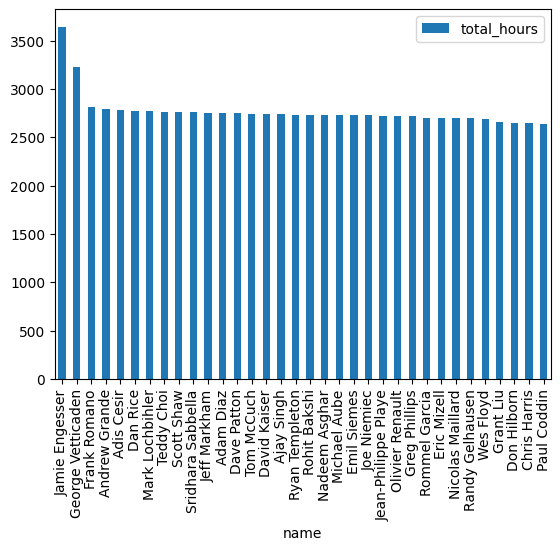

In [15]:
sql = """
SELECT 
    d.driverId, 
    d.name, 
    t.total_hours, 
    t.total_miles 
FROM 
    drivers d
JOIN (
    SELECT 
        driverId, 
        sum(hours_logged) total_hours, 
        sum(miles_logged) total_miles 
    FROM 
        timesheet 
    GROUP BY 
        driverId 
    ) t
ON 
    (d.driverId = t.driverId)
ORDER BY
    t.total_hours DESC;
"""

with engine.connect().execution_options(autocommit=True) as conn:
    query = conn.execute(text(sql))

df = pd.DataFrame(query.fetchall())


import matplotlib as mpl
import matplotlib.pyplot as plt

df.plot.bar(x="name", y="total_hours");

Almacenamiento de los resultados
---

In [16]:
sql = """
SELECT 
    d.driverId, 
    d.name, 
    t.total_hours, 
    t.total_miles 
FROM 
    drivers d
JOIN (
    SELECT 
        driverId, 
        sum(hours_logged) total_hours, 
        sum(miles_logged) total_miles 
    FROM 
        timesheet 
    GROUP BY 
        driverId 
    ) t
ON 
    (d.driverId = t.driverId)
ORDER BY
    d.name;
"""

with engine.connect().execution_options(autocommit=True) as conn:
    query = conn.execute(text(sql))

pd.DataFrame(query.fetchall()).to_csv("/tmp/summary.csv", index=False)

2023-04-03 17:32:52,649 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-03 17:32:52,651 INFO sqlalchemy.engine.Engine 
SELECT 
    d.driverId, 
    d.name, 
    t.total_hours, 
    t.total_miles 
FROM 
    drivers d
JOIN (
    SELECT 
        driverId, 
        sum(hours_logged) total_hours, 
        sum(miles_logged) total_miles 
    FROM 
        timesheet 
    GROUP BY 
        driverId 
    ) t
ON 
    (d.driverId = t.driverId)
ORDER BY
    d.name;

2023-04-03 17:32:52,652 INFO sqlalchemy.engine.Engine [generated in 0.00241s] ()
2023-04-03 17:32:52,654 INFO sqlalchemy.engine.Engine ROLLBACK


In [17]:
#
# !head /tmp/summary.csv
#
with open('/tmp/summary.csv', 'rt') as file:
    lines = file.readlines()

for line in lines[:5]:
    print(line, end="")

driverId,name,total_hours,total_miles
23,Adam Diaz,2750,137980
14,Adis Cesir,2781,136624
19,Ajay Singh,2738,137968
36,Andrew Grande,2795,138025
